In [1]:
import pandas as pd

vegas = pd.read_csv('data/tiles_Vegas.csv', index_col=0)
paris = pd.read_csv('data/tiles_Paris.csv', index_col=0)
shanghai = pd.read_csv('data/tiles_Shanghai.csv', index_col=0)
khartoum = pd.read_csv('data/tiles_Khartoum.csv', index_col=0)

df = pd.concat([vegas, paris, shanghai, khartoum]).reset_index()

df_20cities = pd.read_csv('data/20cities_dataset.csv', index_col=0)

print((df_20cities.shape[0] + df.shape[0]) // 8)
print(df.shape)

df.head(5)

881
(2549, 5)


index                                               tile  \
0      0  /home/just3mhz/Diploma/RoadGraphExtraction/dat...   
1      1  /home/just3mhz/Diploma/RoadGraphExtraction/dat...   
2      2  /home/just3mhz/Diploma/RoadGraphExtraction/dat...   
3      3  /home/just3mhz/Diploma/RoadGraphExtraction/dat...   
4      4  /home/just3mhz/Diploma/RoadGraphExtraction/dat...   

                                                mask  \
0  /home/just3mhz/Diploma/RoadGraphExtraction/dat...   
1  /home/just3mhz/Diploma/RoadGraphExtraction/dat...   
2  /home/just3mhz/Diploma/RoadGraphExtraction/dat...   
3  /home/just3mhz/Diploma/RoadGraphExtraction/dat...   
4  /home/just3mhz/Diploma/RoadGraphExtraction/dat...   

                                               graph   city  
0  /home/just3mhz/Diploma/RoadGraphExtraction/dat...  Vegas  
1  /home/just3mhz/Diploma/RoadGraphExtraction/dat...  Vegas  
2  /home/just3mhz/Diploma/RoadGraphExtraction/dat...  Vegas  
3  /home/just3mhz/Diploma/RoadGraphExtraction/dat...  Vegas  
4  /home/just3mhz/Diploma/RoadGraphExtraction/dat...  Vegas

In [2]:
import cv2
import pylab as plt

image_size = 512

tile = cv2.imread(df_20cities.loc[0, 'tile'])
mask = cv2.imread(df_20cities.loc[0, 'mask'], cv2.IMREAD_GRAYSCALE)


fig, ax = plt.subplots(1, 2, figsize=(10, 20))

ax[0].imshow(tile)
ax[1].imshow(mask)

ModuleNotFoundError: No module named 'cv2'

/tmp/ipykernel_2189/664416822.py:9: FutureWarning: `selem` is a deprecated argument name for `dilation`. It will be removed in version 1.0. Please use `footprint` instead.
  mask_dilation = dilation(mask, selem=disk(DILATION_SIZE))


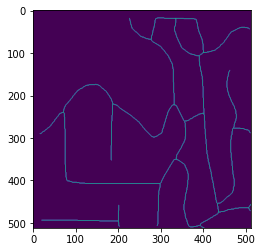

In [3]:
import numpy as np
from skimage.morphology import skeletonize, dilation, disk


DILATION_SIZE = 4
MAX_DISTANCE_FROM_LINE_TO_SPLIT = 2
CLIP_THRESHOLD = 0.3

mask_dilation = dilation(mask, selem=disk(DILATION_SIZE))

mask_clip = np.zeros_like(mask_dilation)
mask_clip[mask_dilation > 255 * CLIP_THRESHOLD] = 1

skeleton = skeletonize(mask_clip).astype(np.uint16)

plt.imshow(skeleton)

In [4]:
import sknw


graph = sknw.build_sknw(skeleton, multi=True)

# def plot_graph(ax, graph, background):
#     ax.imshow(background)
    
#     # draw edges by pts
#     for (s,e) in graph.edges():
#         ps = graph[s][e]['pts']
#         plt.plot(ps[:,1], ps[:,0], 'green')
        
#     nodes = graph.nodes()
#     ps = np.array([nodes[i]['o'] for i in nodes])
#     plt.plot(ps[:,1], ps[:,0], 'r.')
    
# plot_graph(plt, graph, tile)

print(graph)

MultiGraph with 30 nodes and 32 edges


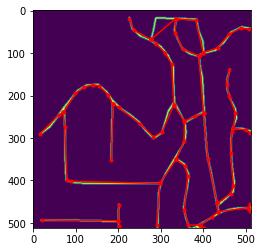

In [5]:
import math

def simplify_edge(ps: np.ndarray, max_distance=3):
    """
    Combine multiple points of graph edges to line segments
    so distance from points to segments <= max_distance
    :param ps: array of points in the edge, including node coordinates
    :param max_distance: maximum distance, if exceeded new segment started
    :return: ndarray of new nodes coordinates
    """
    res_points = []
    cur_idx = 0
    # combine points to the single line while distance from the line to any point < max_distance
    for i in range(1, len(ps) - 1):
        segment = ps[cur_idx:i + 1, :] - ps[cur_idx, :]
        angle = -math.atan2(segment[-1, 1], segment[-1, 0])
        ca = math.cos(angle)
        sa = math.sin(angle)
        # rotate all the points so line is alongside first column coordinate
        # and the second col coordinate means the distance to the line
        segment_rotated = np.array([[ca, -sa], [sa, ca]]).dot(segment.T)
        distance = np.max(np.abs(segment_rotated[1, :]))
        if distance > max_distance:
            res_points.append(ps[cur_idx, :])
            cur_idx = i
    if len(res_points) == 0:
        res_points.append(ps[0, :])
    res_points.append(ps[-1, :])

    return np.array(res_points)

def draw_original_graph(graph):
    # draw original points in green/red
    for (s, e) in graph.edges():
        for _, val in graph[s][e].items():
            ps = val['pts']
            plt.plot(ps[:, 1], ps[:, 0], 'green')

            for node in (graph.nodes[s], graph.nodes[e]):
                plt.plot(node['o'][1], node['o'][0], 'r.')

def simplify_graph(graph, max_distance=2):
    """
    :type graph: MultiGraph
    """
    all_segments = []
    for (s, e) in graph.edges():
        for _, val in graph[s][e].items():
            ps = val['pts']
            full_segments = np.row_stack([
                graph.nodes[s]['o'],
                ps,
                graph.nodes[e]['o']
            ])

            segments = simplify_edge(full_segments, max_distance=max_distance)
            all_segments.append(segments)

    return all_segments

def draw_segments(ax, all_segments, background=None):
    if background is not None:
        ax.imshow(background)
    for segments in all_segments:
        ax.plot(segments[:, 1], segments[:, 0], 'red', marker='.')

simplified = simplify_graph(graph)
draw_segments(plt, simplified, background=mask)

In [6]:
import tensorflow as tf
from tensorflow.keras import layers


class Reader:
    def __init__(self, df, w=512, h=512):
        self.df = df
        self.w = w
        self.h = h
        
    def __call__(self):
        print('\nStart reading from 20cities')
        for index, row in self.df.iterrows():
            tile = self._read_tile(row['tile'])
            mask = self._read_mask(row['mask'])
            yield tile, mask
        print('\nFinish reading from 20cities')
            
    def _read_mask(self, path):
        mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        mask = np.where(mask > 0, 1.0, 0.0)
        mask = mask.reshape([self.w, self.h, 1]) #
        return mask
    
    def _read_tile(self, path):
        tile = cv2.imread(path)
        return tile
            
class AOIReader:
    def __init__(self, df, w=512, h=512):
        self.df = df
        self.w = w
        self.h = h
        
    def __call__(self):
        print('\nStart reading from spacenet')
        for index, row in self.df.iterrows():
            tile = self._read_tile(row['tile'])
            mask = self._read_mask(row['mask'])
            yield tile, mask
        print('\nFisnish reading from spacenet')
        
        
    def _read_mask(self, path):
        mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (self.w, self.h)) 
        mask = np.where(mask > 0, 1.0, 0.0)
        mask = mask.reshape([self.w, self.h, 1]) # ???
        return mask
    
    def _read_tile(self, path):
        tile = cv2.imread(path)
        tile = cv2.resize(tile, (self.w, self.h))
        return tile

            
class Flip(layers.Layer):
    def __init__(self, seed=42):
        super().__init__()
        self.augment_tile = layers.RandomFlip(seed=seed)
        self.augment_mask = layers.RandomFlip(seed=seed)
    
    def call(self, tile, mask):
        tile = self.augment_tile(tile)
        mask = self.augment_mask(mask)
        return tile, mask
            
image_size = (512, 512)
dataset_aoi = tf.data.Dataset.from_generator(AOIReader(df),
                                        output_signature=(
                                            tf.TensorSpec(shape=image_size+(3,), dtype=tf.float32),
                                            tf.TensorSpec(shape=image_size+(1,), dtype=tf.float32)
                                        ))


dataset_20cities = tf.data.Dataset.from_generator(Reader(df_20cities),
                                        output_signature=(
                                            tf.TensorSpec(shape=image_size+(3,), dtype=tf.float32),
                                            tf.TensorSpec(shape=image_size+(1,), dtype=tf.float32)
                                        ))

dataset = dataset_aoi.concatenate(dataset_20cities)\
            .cache()\
            .batch(8)\
            .repeat()    

2022-05-20 18:43:56.622202: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-20 18:44:04.289139: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13579 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:8b:00.0, compute capability: 7.5


In [7]:
import segmentation_models as sm

model = tf.keras.models.load_model('linknet50_fulldataset', {
    'dice_loss': sm.losses.dice_loss,
    'f1-score': sm.metrics.f1_score,
    'iou_score': sm.metrics.iou_score
})

Segmentation Models: using `keras` framework.


In [18]:
model.fit(dataset, epochs=5, steps_per_epoch=881)

Epoch 1/5
881/881 [==============================] - 601s 683ms/step - loss: 0.1824 - accuracy: 0.9696 - f1-score: 0.8176 - iou_score: 0.6946
Epoch 2/5
881/881 [==============================] - 607s 689ms/step - loss: 0.1752 - accuracy: 0.9708 - f1-score: 0.8248 - iou_score: 0.7048
Epoch 3/5
881/881 [==============================] - 607s 688ms/step - loss: 0.1731 - accuracy: 0.9711 - f1-score: 0.8270 - iou_score: 0.7079
Epoch 4/5
881/881 [==============================] - 607s 688ms/step - loss: 0.1715 - accuracy: 0.9712 - f1-score: 0.8286 - iou_score: 0.7103
Epoch 5/5
881/881 [==============================] - 607s 689ms/step - loss: 0.1703 - accuracy: 0.9714 - f1-score: 0.8298 - iou_score: 0.7120


In [19]:
model.save('linknet50_fulldataset')

INFO:tensorflow:Assets written to: linknet50_fulldataset/assets


/home/just3mhz/Diploma/RoadGraphExtraction/venv/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/home/just3mhz/Diploma/RoadGraphExtraction/venv/lib/python3.8/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [39]:
reader = Reader(df_20cities.sample(n=8))

tiles = []
masks = []
for tile, mask in reader():
    tiles.append(tile)
    masks.append(mask)
    
tiles = np.array(tiles)
masks = np.array(masks)


Start reading from 20cities

Finish reading from 20cities


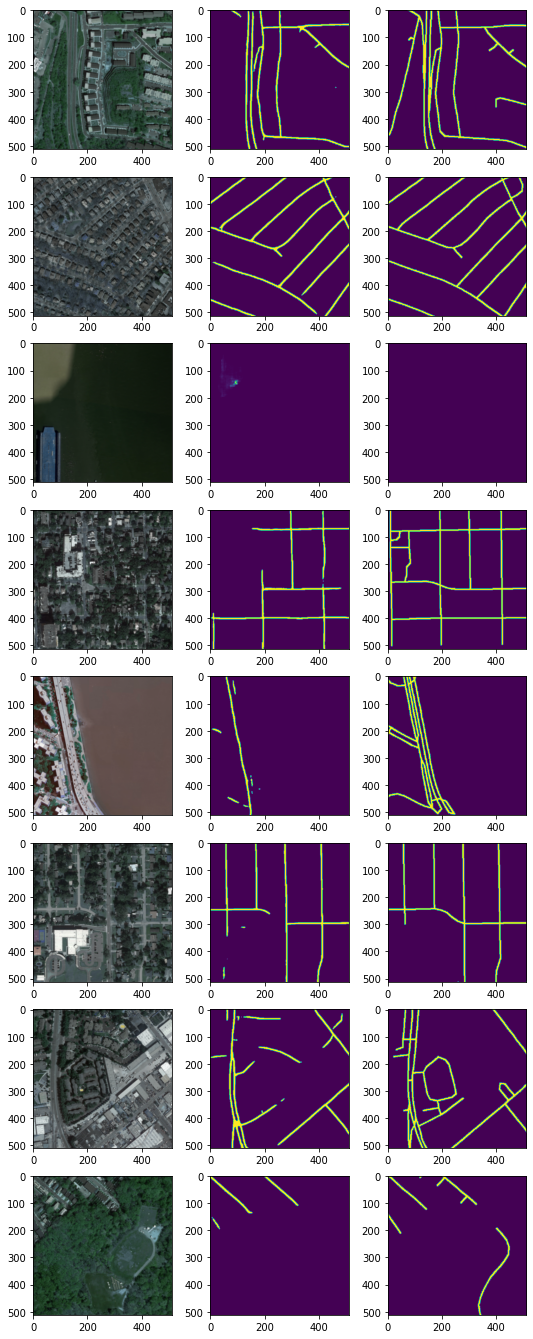

In [40]:
prediction = model.predict(tiles)

fig, ax = plt.subplots(8, 3, figsize=(9, 24))

for i in range(8):
    ax[i, 0].imshow(tiles[i])
    ax[i, 1].imshow(prediction[i])
    ax[i, 2].imshow(masks[i])

MultiGraph with 29 nodes and 27 edges
MultiGraph with 17 nodes and 12 edges
MultiGraph with 0 nodes and 0 edges
MultiGraph with 52 nodes and 54 edges
MultiGraph with 39 nodes and 30 edges
MultiGraph with 44 nodes and 46 edges
MultiGraph with 0 nodes and 0 edges
MultiGraph with 17 nodes and 14 edges


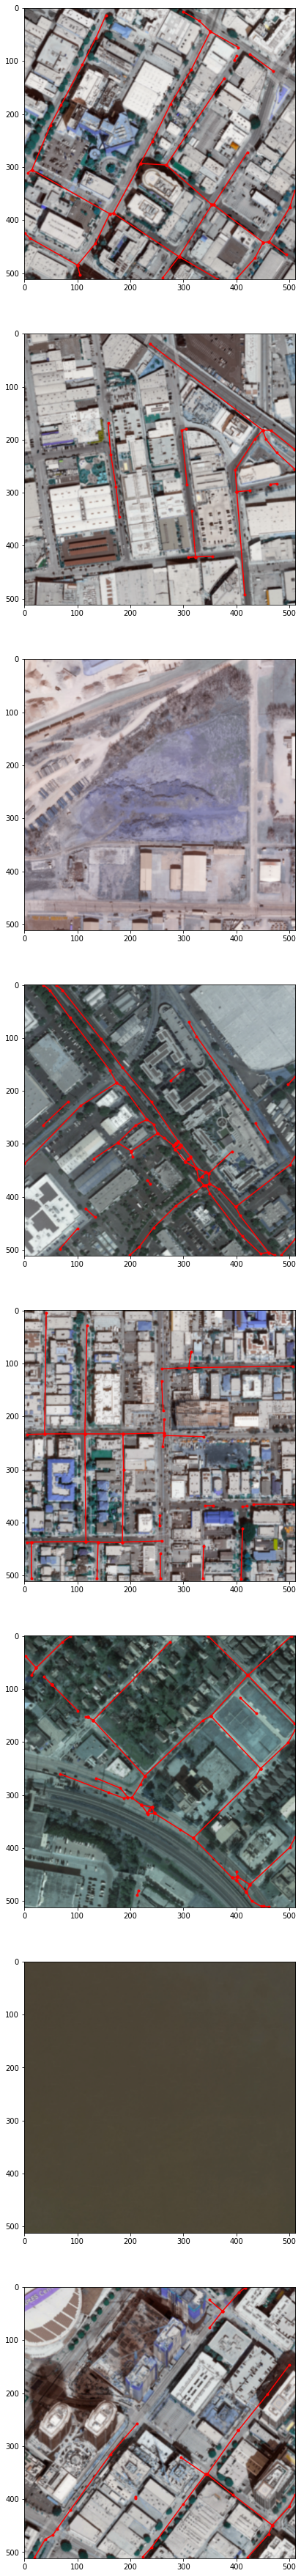

In [22]:
def make_graph(msk):
    DILATION_SIZE = 4
    MAX_DISTANCE_FROM_LINE_TO_SPLIT = 2
    CLIP_THRESHOLD = 0.3

    msk = dilation(msk, footprint=disk(DILATION_SIZE))

    mask_clip = np.zeros_like(msk)
    mask_clip[msk > 255 * CLIP_THRESHOLD] = 1

    s = skeletonize(mask_clip).astype(np.uint16)

    return sknw.build_sknw(s, multi=True)

fig, ax = plt.subplots(8, 1, figsize=(8, 64))

for i in range(8):
    p = np.where(prediction[i].reshape(512, 512) > 0.5, 255, 0)
    gr = make_graph(p)
    print(gr)
    segments = simplify_graph(gr)
    draw_segments(ax[i], segments, background=tiles[i])

In [41]:
reader = AOIReader(df.sample(n=8))

tiles = []
masks = []
for tile, mask in reader():
    tiles.append(tile)
    masks.append(mask)
    
tiles = np.array(tiles)
masks = np.array(masks)


Start reading from spacenet

Fisnish reading from spacenet


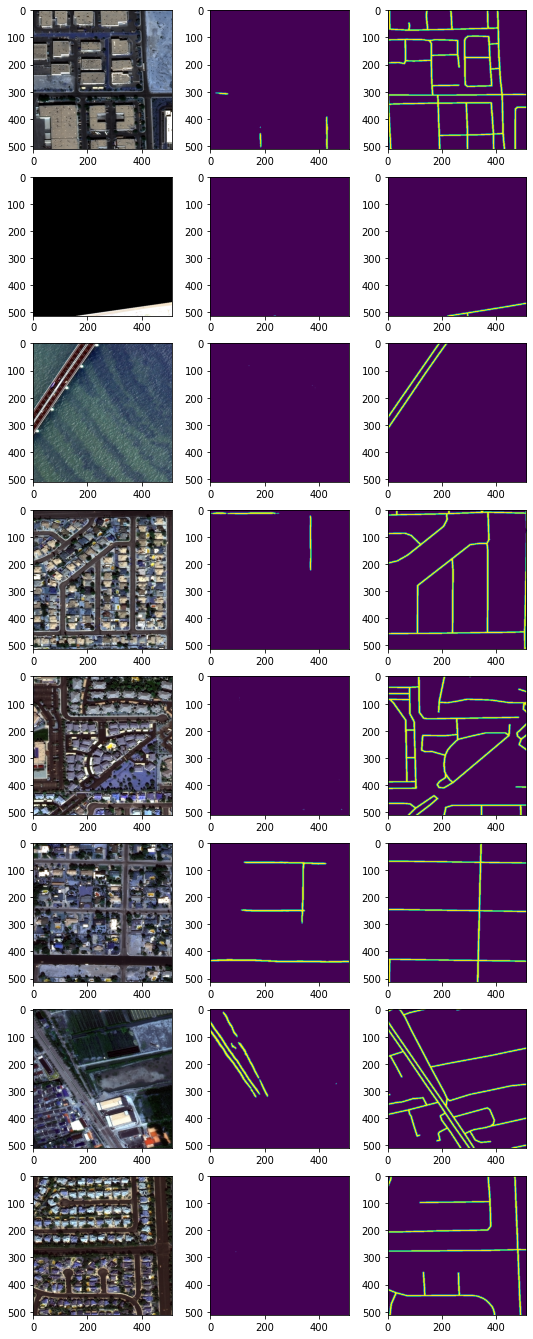

In [42]:
prediction = model.predict(tiles)

fig, ax = plt.subplots(8, 3, figsize=(9, 24))

for i in range(8):
    ax[i, 0].imshow(tiles[i])
    ax[i, 1].imshow(prediction[i])
    ax[i, 2].imshow(masks[i])

MultiGraph with 0 nodes and 0 edges
MultiGraph with 16 nodes and 8 edges
MultiGraph with 15 nodes and 9 edges
MultiGraph with 7 nodes and 3 edges
MultiGraph with 0 nodes and 0 edges
MultiGraph with 14 nodes and 7 edges
MultiGraph with 2 nodes and 1 edges
MultiGraph with 4 nodes and 2 edges


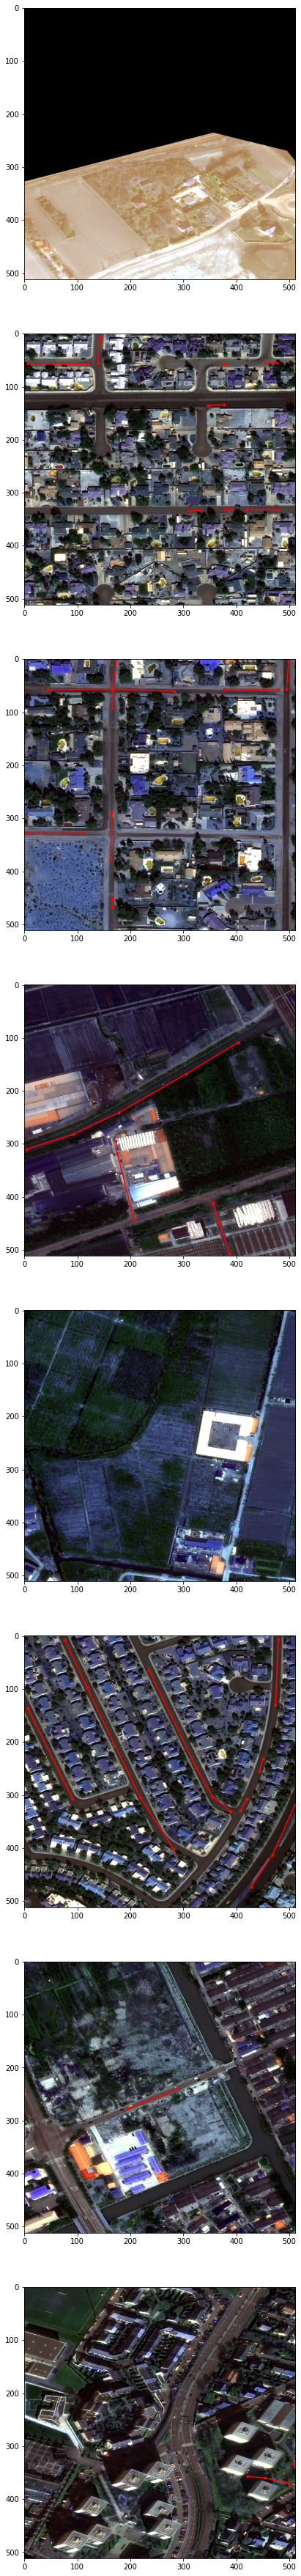

In [25]:
fig, ax = plt.subplots(8, 1, figsize=(8, 64))

for i in range(8):
    p = np.where(prediction[i].reshape(512, 512) > 0.5, 255, 0)
    gr = make_graph(p)
    print(gr)
    segments = simplify_graph(gr)
    draw_segments(ax[i], segments, background=tiles[i])

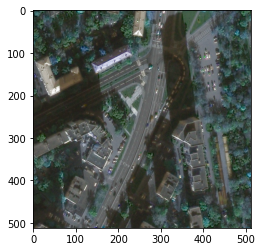

In [37]:
moscow = cv2.imread('data/moscow3.png')
moscow = cv2.resize(moscow, (512, 512))

plt.imshow(moscow)

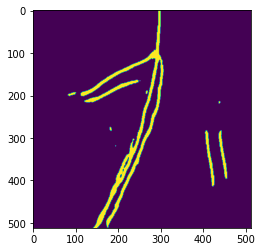

In [38]:
moscow = np.array([moscow])
moscow_p = model.predict(moscow)

plt.imshow(moscow_p[0])